In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('josh_final_dataset_7.14.csv')

In [3]:
del df['Unnamed: 0']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45604 entries, 0 to 45603
Data columns (total 30 columns):
Assets                                                                                                         39525 non-null float64
adsh                                                                                                           39525 non-null object
cik                                                                                                            45604 non-null int64
coreg                                                                                                          54 non-null object
ddate                                                                                                          39525 non-null float64
ein                                                                                                            37612 non-null float64
fy                                                                                            

## Dividing (Identifying) which companies are foreign and domestic

In [5]:
df['check1']=np.where(df.IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign.isnull(),0,1)
df['check2']=np.where(df.UndistributedEarningsOfForeignSubsidiaries.isnull(),0,1)
df['check3']=np.where(df.ForeignEarningsRepatriated.isnull(),0,1)

df['check']=df['check1']+df['check2']+df['check3']

In [6]:
del df['check1']
del df['check2']
del df['check3']

In [7]:
# Giving identifiers to companies as to whether each of them has foreign subsidiary(foreign operation) or not
df['Type of Firm'] = np.where(df.check==0,'Domestic','Foreign')

In [8]:
del df['check']

## Giving each company industry classification & Creating [Foreign Income/Assets]

"IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign" tag

In [9]:
industry_count =\
pd.DataFrame([{'Mining and Construction':3551, 'Manufacturing':13162, 'Transportation, Communication, Electric, Gas':2889,
 'Wholesale, Retail':3116,'Financial, Insurance, Real Estate':9625, 'Services':6725,'Public Administration':103}],index=['count'])

# industry_count.to_csv('industry_count_breakdown.csv')

In [10]:
industry_count

,"Financial, Insurance, Real Estate",Manufacturing,Mining and Construction,Public Administration,Services,"Transportation, Communication, Electric, Gas","Wholesale, Retail"
count,9625,13162,3551,103,6725,2889,3116


In [11]:
# bins = pd.IntervalIndex.from_tuples([(1000, 1999), (2000, 3999),(4000,4999),(5000,5999),
#                                     (6000,6999),(7000,8999),(9000,9999)],closed='both')

df['industry']=\
pd.cut(df.sic.tolist(),[1000,1999,3999,4999,5999,6999,8999,9999],include_lowest=True,
             labels=['Mining and Construction','Manufacturing','Transportation, Communication, Electric, Gas',
               'Wholesale, Retail','Financial, Insurance, Real Estate','Services','Public Administration'])

In [12]:
# Creating new variable (R&D / Assets)
df['Foreign_Income_scaled']=\
df['IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign']/df['Assets']

## Limiting data to fixed fy years for accurate analysis

In [13]:
# Data only from fy 2013 to fy 2016
df_13_16 = df[(df.fy>=2013) & (df.fy<=2016)]

# Drop firms that have at least one missing Asset values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Assets'])))

# Drop firms that have Asset value of 0
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(x['Assets']!=0.0))

# Drop firms that have at least one missing R&D values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Liabilities'])))

# Filter only the companies that have data for all fy years 2013 - 2016 (4 assets values per cik group)
# df_13_16 = df_13_16.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

df_13_16_foreign = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Foreign']
df_13_16_domestic = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Domestic']

As we can see below, the problem is there are some firms that was domestic one year and was multinational for another year (inconsistent). We are going to drop those companies and exclude them from the analysis

In [14]:
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    806
2014.0    839
2015.0    853
2016.0    846
dtype: int64 

 Domestic: fy
2013.0    2381
2014.0    2312
2015.0    2086
2016.0    2000
dtype: int64


In [15]:
# Dropping MNCs that have missing UFEs for all years
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: all(pd.notnull(x['UndistributedEarningsOfForeignSubsidiaries'])))

In [16]:
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: x['fy'].nunique()==4)
df_13_16_domestic = df_13_16_domestic.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

# Now we have the same number of multinational firms and domestic firms throughout all years
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    263
2014.0    263
2015.0    263
2016.0    263
dtype: int64 

 Domestic: fy
2013.0    1344
2014.0    1344
2015.0    1344
2016.0    1344
dtype: int64


In [17]:
# Make a new dataframe df_13_16 with the modified foreign and domestic firms data
df_13_16= df_13_16_foreign.append(df_13_16_domestic)

## Comparison by Industry

- Industry1: 'Mining and Construction'
- Industry2: 'Manufacturing'
- Industry3: 'Transportation, Communication, Electric, Gas'
- Industry4: 'Wholesale, Retail'
- Industry5: 'Financial, Insurance, Real Estate'
- Industry6: 'Services'
- Industry7: 'Public Administration'

In [18]:
# Dividing data into 7 different industries

foreign_income_industry1 = df_13_16.copy()[df_13_16.copy().industry=='Mining and Construction']
foreign_income_industry2 = df_13_16.copy()[df_13_16.copy().industry=='Manufacturing']
foreign_income_industry3 = df_13_16.copy()[df_13_16.copy().industry=='Transportation, Communication, Electric, Gas']
foreign_income_industry4 = df_13_16.copy()[df_13_16.copy().industry=='Wholesale, Retail']
foreign_incomeindustry5 = df_13_16.copy()[df_13_16.copy().industry=='Financial, Insurance, Real Estate']
foreign_income_industry6 = df_13_16.copy()[df_13_16.copy().industry=='Services']
foreign_income_industry7 = df_13_16.copy()[df_13_16.copy().industry=='Public Administration']

### Industry 2: Manufacturing

In [19]:
# Count of firms in Manufacturing
foreign_income_industry2_count =\
pd.DataFrame(foreign_income_industry2[foreign_income_industry2['IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign'].notnull()].\
             loc[:,['cik','fy','Type of Firm','IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign']].\
             groupby(['fy','Type of Firm'])['IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign'].count()).reset_index()

In [20]:
# Mean of (Liabilities/ Assets) of firms in Manufacturing per year
foreign_income_industry2_mean_scaled =\
pd.DataFrame(foreign_income_industry2[foreign_income_industry2['Foreign_Income_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Foreign_Income_scaled']].\
             groupby(['fy','Type of Firm'])['Foreign_Income_scaled'].mean()).reset_index()

### Visualizations

Text(0.5,1,'Count of MNCs (Manufacturing)')

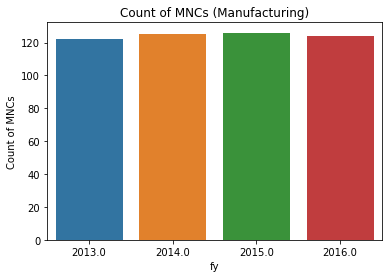

In [21]:
# Count of MNCs
sns.barplot(x='fy',y='IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign',data= foreign_income_industry2_count)
plt.ylabel('Count of MNCs')
plt.title('Count of MNCs (Manufacturing)')

In [22]:
foreign_income_industry2['UndistributedEarningsOfForeignSubsidiaries_scaled']=\
foreign_income_industry2['UndistributedEarningsOfForeignSubsidiaries']/foreign_income_industry2['Assets']

Text(0,0.5,'Mean of Foreign Income normalized')

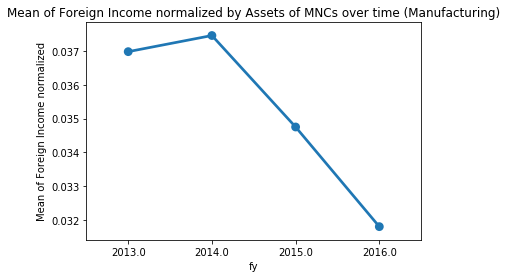

In [23]:
# Foreign Income normalized by Assets over time
sns.pointplot(x='fy', y='Foreign_Income_scaled',data=foreign_income_industry2_mean_scaled)

plt.title('Mean of Foreign Income normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean of Foreign Income normalized')

Text(0.5,1,'Mean Undistributed Foreign Earnings normalized (Manufacturing)')

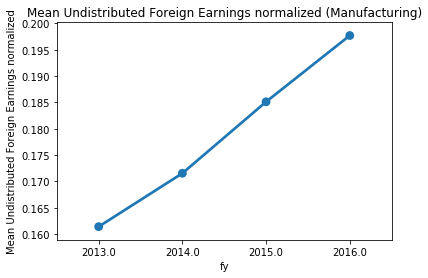

In [105]:
# Mean Normalized Undistributed Foreign Earnings of Manufacturing Industry

sns.pointplot(x='fy',y='UndistributedEarningsOfForeignSubsidiaries_scaled',
              data= pd.DataFrame(foreign_income_industry2[foreign_income_industry2['Type of Firm']=='Foreign'].\
             groupby(['fy'])['UndistributedEarningsOfForeignSubsidiaries_scaled'].mean()).reset_index())

plt.ylabel('Mean Undistributed Foreign Earnings normalized')
plt.title('Mean Undistributed Foreign Earnings normalized (Manufacturing)')

In [24]:
df

,Assets,adsh,cik,coreg,ddate,ein,fy,fye,period,sic,...,ForeignEarningsRepatriated,IncomeLossFromContinuingOperationsBeforeIncomeTaxesDomestic,ResearchAndDevelopmentExpense,Liabilities,NetIncomeLoss,GrossProfit,ProfitLoss,Type of Firm,industry,Foreign_Income_scaled
0,1.703727e+09,0001047469-11-006302,1750,NaN,20110531.0,362334820.0,2011.0,531.0,20110531.0,3720.0,...,NaN,NaN,NaN,NaN,6.982600e+07,NaN,NaN,Domestic,Manufacturing,NaN
1,2.195700e+09,0001104659-12-065381,1750,NaN,20120531.0,362334820.0,2012.0,531.0,20120531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,Manufacturing,NaN
2,2.136900e+09,0001104659-13-072128,1750,NaN,20130531.0,362334820.0,2013.0,531.0,20130531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,Manufacturing,NaN
3,2.199500e+09,0001104659-14-067921,1750,NaN,20140531.0,362334820.0,2014.0,531.0,20140531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic,Manufacturing,NaN
4,1.515000e+09,0001047469-15-006136,1750,NaN,20150531.0,362334820.0,2015.0,531.0,20150531.0,3720.0,...,NaN,NaN,NaN,NaN,1.020000e+07,1.593000e+08,1.040000e+07,Domestic,Manufacturing,NaN
5,1.442100e+09,0001047469-16-014299,1750,NaN,20160531.0,362334820.0,2016.0,531.0,20160531.0,3720.0,...,NaN,NaN,NaN,NaN,4.770000e+07,2.369000e+08,4.770000e+07,Domestic,Manufacturing,NaN
6,1.504100e+09,0001047469-17-004528,1750,NaN,20170531.0,362334820.0,2017.0,531.0,20170531.0,3720.0,...,NaN,NaN,NaN,NaN,5.650000e+07,2.765000e+08,5.650000e+07,Domestic,Manufacturing,NaN
7,5.241662e+10,0001047469-10-001018,1800,NaN,20091231.0,360698440.0,2009.0,1231.0,20091231.0,2834.0,...,NaN,NaN,NaN,5.694000e+09,NaN,NaN,5.745838e+09,Domestic,Manufacturing,NaN
8,5.946227e+10,0001047469-11-001056,1800,NaN,20101231.0,360698440.0,2010.0,1231.0,20101231.0,2834.0,...,NaN,-275000000.0,NaN,NaN,NaN,5.922800e+09,4.626172e+09,Foreign,Manufacturing,0.095725
9,6.027689e+10,0001047469-12-001216,1800,NaN,20111231.0,360698440.0,2011.0,1231.0,20111231.0,2834.0,...,NaN,364000000.0,NaN,NaN,NaN,6.539600e+09,NaN,Foreign,Manufacturing,0.080213
